# Statistics and data analysis

In this lesson, we are going to build on our first steps with pandas in the previous and learn how it can be used to efficiently handle large datasets. 

We will work on some real world data to show pandas, scipy and matplotlib are applied. A caveat to begin with, though: all these libraries are tools that help you get stuff done more easily and quickly. Like any tool, they can be used completely wrong. For example, you can apply many different  statistical tests in a single line of code using scipy.stats, but nobody stops you from using a test that isn't the correct one for your data. That is on you. To be honest, I am not 100% sure if all the things I am doing in this section are 100% sound. Some of it is definitely outside my area of expertise. If you find a mistake, please let me know and I will correct ASAP.

In [46]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline

## Statistical descriptors and statistical testing

In our first example, we have a dataset of different methods for determination of CO<sub>2</sub> mass percent in a anhydrous sodium carbonate sample. We will determine the confidence interval of each method and see which one of them is the most precise and accurate. The raw data looks like this:

![CO2 dataset](figures/statistics/CO2.png)

Step one: load data into `pandas.DataFrame`. Delimiters are arbitrary numbers of spaces. And there are a few skipped lines and a header. To use arbitrary white space as delimiter in pandas, we use the delim_whitespace optional argument. (Reminder: if you don't know what arguments to pass to a function, just read the documentation):

In [4]:
CO2_df = pd.read_csv("data/CO2_methods_tcm18-57755.txt", 
                     skiprows=18,
                    delim_whitespace=True)
CO2_df

Gravimetry  Method1  Method2  Method3  Method4  Method5
0        41.41    41.22    40.91    41.95    40.30    40.80
1        41.62    41.41    40.61    41.31    40.46    40.88
2        41.48    40.30    40.02    39.09    39.50    41.24
3        41.44    40.34    40.16    40.59    39.53    41.03
4        41.50    40.70    40.54    41.65    39.95    41.53
5        41.51    41.16    40.61    42.90    41.21      NaN
6        41.43    40.74    40.61    41.30    40.96      NaN
7        41.51    40.23    41.09      NaN      NaN      NaN
8        41.59    40.82      NaN      NaN      NaN      NaN
9        40.93      NaN      NaN      NaN      NaN      NaN
10       40.89      NaN      NaN      NaN      NaN      NaN

The nice printout of the data frame shows us that things - again - don't work right away. It seems, that consecutive runs of spaces were stripped until the first number was reached and then that number  was put into the first column. After reading all the options for `read_csv`, it turns out there might not be a good way to configure the function to import the dataset, because we are in fact not looking at at delimited format but at a "fixed width" format. These have the same number of characters for each column or at least a constant number for each column across all lines. Superfluous characters are filled with spaces. A quick internet search for "open fixed width format pandas" points us to the `read_fwf` function. 

The reason I am including this circuitous route to loading the data is, that getting a dataset into a shape that we can work with is often one of the harder parts of a new project. A lot of things can go wrong at this point and lack of documentation and standards make it hard to come up with a one size fits all solution. The only thing to do is to be cautious, check and recheck if what you think you loaded is actually what python loaded and try all the tools that panda, numpy, scipy or third party projects make available to you.

Using the more adept function, we get the following: 

In [5]:
CO2_df = pd.read_fwf("data/CO2_methods_tcm18-57755.txt", 
                     skiprows=18)
CO2_df

Gravimetry  Method1  Method2  Method3  Method4  Method5
0        41.41    41.22    40.91    41.95    40.30    40.80
1        41.62    41.41    40.61    41.31    40.46    40.88
2        41.48    40.30    40.02    39.09    39.50    41.24
3        41.44    40.34    40.16    40.59    39.53    41.03
4        41.50    40.70    40.54    41.65    39.95    41.53
5        41.51    41.16    40.61    42.90      NaN    41.21
6        41.43    40.74    40.61    41.30      NaN    40.96
7        41.51    40.23      NaN      NaN      NaN    41.09
8        41.59    40.82      NaN      NaN      NaN      NaN
9          NaN    40.93      NaN      NaN      NaN      NaN
10         NaN    40.89      NaN      NaN      NaN      NaN

To determine mean and standard deviation, we can use methods  `.mean()` and `.std()` of the dataframe. 

In [6]:
CO2_df.mean()

Gravimetry    41.498889
Method1       40.794545
Method2       40.494286
Method3       41.255714
Method4       39.948000
Method5       41.092500
dtype: float64

In [7]:
CO2_df.std()

Gravimetry    0.070435
Method1       0.387721
Method2       0.303252
Method3       1.188807
Method4       0.436314
Method5       0.232732
dtype: float64

To check if our methods are accurate we will use a one-sample t test to evaluate if the true value of 41.518% mass of CO<sub>2</sub> is significantly different from the mean measurement results for each method.

In [8]:
CO2_true_value = 41.518

The one sample t-test is called `ttest_1samp` in `scipy.stats`:

In [9]:
from scipy.stats import ttest_1samp

We need to apply it to each columns of our dataframe separately. We will do this using the `.apply` method. We also need to set some of the arguments to set the mean value to test and tell  `ttest_1samp` how to handle `nan`s. We will use a   `lambda ` function to wrap `ttest_1samp` and set those arguments.

```{note} 
`lambda` functions were introduced in the second set of exercises. In case you haven't done them yet, I will briefly summarize `lambda` functions.

`lambda` functions are a way to define inline functions. Their syntax is the keyword `lambda` followed by the argument names  and a colon. Following the colon is a single python statement - the functions body. The return value of the function is whatever the single statement evaluates to. `lambda` functions don't have name and are not kept around unless they are stored in a variable.
```

In [10]:
CO2_df.apply(lambda col: ttest_1samp(col, 
                                     popmean=CO2_true_value,
                                     nan_policy="omit").pvalue)

Gravimetry    0.439207
Method1       0.000103
Method2       0.000110
Method3       0.580667
Method4       0.001295
Method5       0.001293
dtype: float64

The series we just calculated contains p-values for the t-test by column. To see if the mean of the sampled distributions of measurement values is significantly different from the  true value of mass% of CO<sub>2</sub> we have to compare p-values to the $\alpha$ (e.g. 0.05). We have to reject the Null hypothesis (the mean of the distribution is equal to the true value) for all $p < \alpha$ 

In [11]:
accurate = CO2_df.apply(lambda col: ttest_1samp(col, 
                                     popmean=CO2_true_value,
                                     nan_policy="omit").pvalue)>0.05
accurate

Gravimetry     True
Method1       False
Method2       False
Method3        True
Method4       False
Method5       False
dtype: bool

Only Gravimetry and Method3  do not show bias.

Because it doesn't make much sense to calculate confidence intervals for methods that we now know are accurate, we will create a new dataset that only contains accurate methods (using boolean indexing).

:::{hint}
Remember: For boolean indexing, we create a series, dataframe or numpy array full of boolean values and use it together with the indexing square brackets syntax `[]` to select rows.  This will select all elements where the boolean array was true.  We can also use boolean indexing with `.loc` in pandas to select columns, by replacing the first argument with a colon. 
:::
 
The resulting dataframe we are creating below only contains methods which we consider accurate:

In [12]:
CO2_df_accurate =  CO2_df.loc[:,accurate]
CO2_df_accurate

Gravimetry  Method3
0        41.41    41.95
1        41.62    41.31
2        41.48    39.09
3        41.44    40.59
4        41.50    41.65
5        41.51    42.90
6        41.43    41.30
7        41.51      NaN
8        41.59      NaN
9          NaN      NaN
10         NaN      NaN

Since there was a different number of measurements for each method, we can't compare the standard deviations directly to determine which method is more precise. Instead, we will use the confidence intervals, using the 95% confidence interval. The formula for the confidence interval data with empirical standard deviation is: 

$$\bar{x}\pm t_{1-\alpha/2,n-1}^*\frac{s}{\sqrt{n}}$$

with $\bar{x}$ being the empirical mean, $s$ the empirical standard deviation and $n$ being the number of samples,  $\alpha$ is the confidence level subtracted from 1.

The quantile values of `t` are provided by  `t.ppf()`  from the scipy `scipy.stats` package.

In [13]:
from scipy.stats import t

t.ppf(1-0.05/2, 3)

3.182446305284263

Since $n$, $s$ and $\bar{x}$ vary from one method to the next, we need to be careful not to mix up data. This is were pandas really shines: all we need to know is, that the number of non-nan values in each column is determined using the `.count()` method, and we can just fill in the values in the above formula:

In [14]:
n = CO2_df_accurate.count()
s = CO2_df_accurate.std()

conf_int = t.ppf(1-0.05/2, n-1) *s/np.sqrt(n)
conf_int

Gravimetry    0.054141
Method3       1.099463
dtype: float64

We can either create a new dataframe that we put the values we just created into or we create a dictionary that has the new column names as key and the `Series` objects that were the results from our calculation as items.

In [15]:
CO2_conf_int = pd.DataFrame(
    {"mean":CO2_df_accurate.mean(), 
     "confidence interval (95%)":conf_int})
CO2_conf_int

mean  confidence interval (95%)
Gravimetry  41.498889                   0.054141
Method3     41.255714                   1.099463

Alternatively, we can also create a function `calc_conf_int` that calculates the confidence interval given a column as input, like so:

In [16]:
def calc_conf_int(col):
    n = col.count()
    s = col.std()
    return t.ppf(1-0.05/2, n-1) *s/np.sqrt(n)

And then use that function together with the `.agg` method of our dataframe. As you can see the result is a dataframe that has "mean" as the name of the first row and "calc_conf_int" as name of the second row. We can `.rename` and transpose the dataframe to make it looks nicer: 

In [17]:
CO2_df_accurate.agg(func=["mean",calc_conf_int])


Gravimetry    Method3
mean            41.498889  41.255714
calc_conf_int    0.054141   1.099463

In [18]:
CO2_conf_int = CO2_df_accurate.agg(func=["mean",calc_conf_int])\
      .rename({"calc_conf_int": "confidence interval"}).T
CO2_conf_int

mean  confidence interval
Gravimetry  41.498889             0.054141
Method3     41.255714             1.099463

```{note}
Our changes are only stored when we assign the result of in another variable! If we don't do that, they are displayed, if they are the last statement in a cell, otherwise they are just discarded.
```

## Larger datasets

You could have done most of these steps pretty easily by hand as well. However, the neat thing about using a programming language is that things scale. It doesn't make much of difference if you look a 10 values, 100 values or 1000 values (in most cases).

Our next dataset is similar to this one, but much larger. A reference material for river sediment was measured 567 times using ICP-AES by different operators. These measurements were performed in 158 runs  with multiple repeat measurement for each run. For each measurement, the mass fraction in ppb of the following elements was determined:

Li	Na	K	Rb	Be	Mg	Ca	Sr	Ba	Al	La	Ti	V	Cr	Mo	Mn	Fe	Co	Ni	Cu	Ag	Zn	Cd	Pb	P

In [19]:
ICP_df = pd.read_csv("data/AGRG_IQC_text_tcm18-57754.txt", 
                     skiprows=17,
                    delimiter="\t")
ICP_df

Run  Repeat      Li       Na     K      Rb    Be     Mg    Ca    Sr  ...  \
0      1       1  141.79   959.88  8404  112.08  2.87  13018  5957  1337  ...   
1      1       2  140.38   993.00  8449  114.84  2.62  12897  5903  1341  ...   
2      1       3  146.57  1041.38  8698  115.42  2.82  13515  6212  1416  ...   
3      1       4  134.88   905.84  8003  111.40  2.58  12867  5724  1352  ...   
4      1       5  137.74   942.90  8420  112.95  2.64  12964  5849  1341  ...   
..   ...     ...     ...      ...   ...     ...   ...    ...   ...   ...  ...   
544  157       4  148.33   722.74  8283  118.65  2.70  13394  5861  1357  ...   
545  157       5  140.34   633.68  7264  111.46  2.42  12657  5447  1390  ...   
546  158       1  154.20   722.83  8188  120.17  2.71  13400  5925  1337  ...   
547  158       2  155.47   722.67  8223  118.49  2.78  13340  5912  1327  ...   
548  158       3  149.98   699.24  7954  118.61  2.60  13078  5757  1317  ...   

         Mn     Fe     Co      Ni      Cu    Ag      Zn    Cd      Pb       P  
0    1506.0  47564  49.57  255.22  610.57  1.85  377.36  3.09  486.24  628.61  
1    1509.0  47756  49.89  254.45  623.80  1.45  368.19  2.97  508.57  653.63  
2    1289.0  48593  50.22  259.38  608.73  2.12  373.46  2.98  498.67  660.90  
3    1510.0  48072  49.65  250.47  599.31  1.38  374.76  2.98  500.60  645.38  
4    1383.0  47816  48.95  248.25  605.27  1.34  377.83  3.11  490.17  637.00  
..      ...    ...    ...     ...     ...   ...     ...   ...     ...     ...  
544  1515.0  46018  49.82  260.33  616.19  2.67  400.96  3.22  508.44  684.66  
545  1491.0  45980  49.69  259.45  598.30  1.37  388.16  3.08  514.81  673.99  
546  1507.0  44841  48.79  254.08  585.29  1.90  373.68  3.26  504.62  662.64  
547  1474.0  45480  49.13  258.21  609.92  1.82  381.53  3.12  500.19  698.16  
548  1490.0  44474  48.29  251.96  582.67  1.90  375.02  3.17  484.03  655.28  

[549 rows x 27 columns]

There are two values missing, as we can see by `count()`ing the values in each column:

In [20]:
ICP_df.count()

Run       549
Repeat    549
Li        549
Na        549
K         549
Rb        549
Be        549
Mg        549
Ca        549
Sr        549
Ba        549
Al        549
La        549
Ti        549
V         549
Cr        548
Mo        549
Mn        548
Fe        549
Co        549
Ni        549
Cu        549
Ag        549
Zn        549
Cd        549
Pb        549
P         549
dtype: int64

### Visualization

Let's have a look at the trend of the dataset using matplotlib again. We can index columns from the dataframe by using the `[]` indexing syntax and the column name. To get "Run" columns, we would type `ICP_df["Runs"]`  

Text(0, 0.5, 'Fe / ppb')

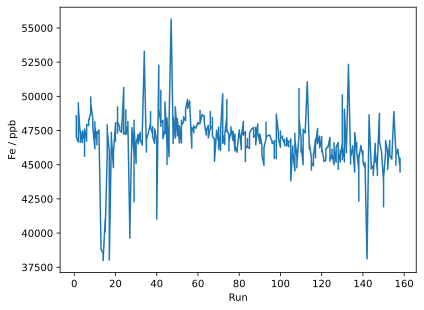

In [21]:
fig_raw = plt.figure()
ax_raw = fig_raw.add_subplot()
ax_raw.plot(ICP_df["Run"], ICP_df["Fe"])
ax_raw.set_xlabel("Run")
ax_raw.set_ylabel("Fe / ppb")

To get an idea of overall trends, we would like to plot all measured elements in a single axes.

To do this in the least amount of lines, we will first get a list of all columns and remove "Run" and "Repeat". Then iterate over all remaining columns:

In [22]:
elements = list(ICP_df.columns)
elements.remove("Run")
elements.remove("Repeat")
print(elements)

['Li', 'Na', 'K', 'Rb', 'Be', 'Mg', 'Ca', 'Sr', 'Ba', 'Al', 'La', 'Ti', 'V', 'Cr', 'Mo', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Ag', 'Zn', 'Cd', 'Pb', 'P']


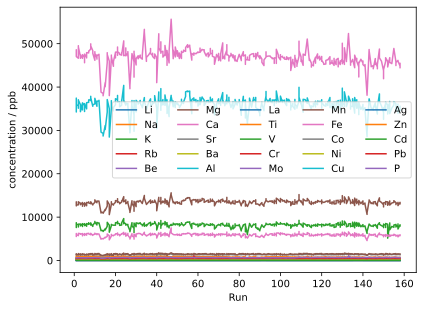

In [23]:
fig_raw = plt.figure()
ax_raw = fig_raw.add_subplot()
for element in elements:
    ax_raw.plot(ICP_df["Run"], 
                ICP_df[element],
               label=element)
ax_raw.set_xlabel("Run")
ax_raw.set_ylabel("concentration / ppb")
ax_raw.legend(ncol=5)

We will normalize to the mean concentration for each element to make the trends a bit clearer:

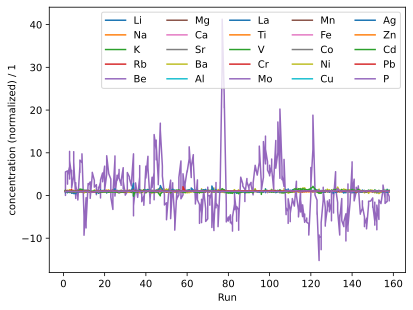

In [24]:
fig_raw = plt.figure()
ax_raw = fig_raw.add_subplot()
for element in elements:
    ax_raw.plot(ICP_df["Run"], 
                ICP_df[element]/ICP_df[element].mean(),
               label=element)
ax_raw.set_xlabel("Run")
ax_raw.set_ylabel("concentration (normalized) / 1")
ax_raw.legend(ncol=5)

Still, this is a bit hard to understand. Especially, because 
we run out of colors. It would be better if we had one axis per element instead. We will use the `.suplots` method to create multiple plots and link their x axes together. Then we loop over all elements and plot one per axis.


We will make our figure a bit higher to accommodate the additional axes. `.subplots` asks us how many rows and columns of plots we want. We want one per element, so `len(elements)`.  Setting `sharex=True` makes all x axes automatically have the same size and scale. The return value of `.subplots()`  is an array of subplots that we store in `axes_raw`.

In the for loop, we use the `enumerate` function, to turn the list of elements into a list of tuples `(<idx>, <element>)`. We then use the `idx` to select a subplot from `axes_raw` to plot into.

The plotting command itself stays the same, but we will add an annotation stating the element in the top right corner of each axes and then adjust the layout a bit to remove space between plots.

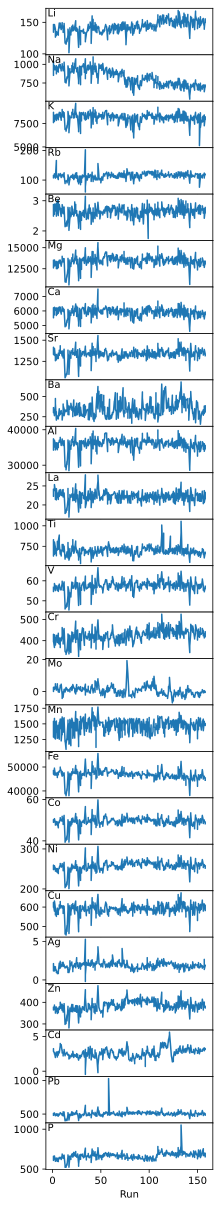

In [25]:
fig_raw = plt.figure(figsize=(3,21))
axes_raw = fig_raw.subplots(nrows=len(elements),
                           sharex=True)

for idx, element in enumerate(elements):
    cur_ax = axes_raw[idx]
    cur_ax.plot(ICP_df["Run"], 
                ICP_df[element],
               label=element)
    cur_ax.annotate(element, 
                   xy=(0.01,.99),
                   xycoords="axes fraction",
                   ha="left",
                   va="top")
fig_raw.subplots_adjust(hspace=0)

axes_raw[-1].set_xlabel("Run");

### GroupBy and Aggregate

Since there were repeated determinations done for the runs, it might be a better idea to look at mean values per run rather than single measurement results. So, we would like to generate a dataframe that contains the average value per run (using the run as row index, and the element as column index): Luckily, that is a two-liner using pandas `.groupby` and `.agg`. First, we group rows by the "Run" column and then `.agg`regate  using the mean.


In [26]:
ICP_mean = ICP_df.groupby("Run").agg("mean")
ICP_mean

Repeat          Li          Na            K         Rb        Be  \
Run                                                                     
1       4.5  138.750000  939.130000  8230.125000  112.54625  2.656250   
2       2.5  143.780000  959.020000  8198.500000  115.40000  2.742500   
3       3.0  133.216000  953.130000  8262.000000  110.50400  2.774000   
4       3.0  132.068000  931.456000  8246.000000  122.46600  2.714000   
5       3.0  132.680000  936.452000  8285.800000  112.39000  2.722000   
..      ...         ...         ...          ...        ...       ...   
154     1.0  148.430000  706.840000  7847.000000  114.04000  2.730000   
155     1.5  154.265000  688.745000  7912.000000  111.89000  2.760000   
156     2.5  151.347500  713.305000  8047.000000  117.02750  2.612500   
157     3.0  143.922000  677.020000  7800.800000  115.32400  2.580000   
158     2.0  153.216667  714.913333  8121.666667  119.09000  2.696667   

               Mg           Ca       Sr          Ba  ...           Mn  \
Run                                                  ...                
1    12923.000000  5827.000000  1360.00  333.563750  ...  1448.250000   
2    13118.750000  5952.500000  1376.00  265.492500  ...  1416.500000   
3    13075.800000  6097.800000  1291.80  422.724000  ...  1433.600000   
4    12930.400000  5962.400000  1299.60  261.926000  ...  1452.600000   
5    12923.400000  5977.200000  1302.40  242.444000  ...  1367.600000   
..            ...          ...      ...         ...  ...          ...   
154  13245.000000  5839.000000  1342.00  283.720000  ...  1401.000000   
155  13586.500000  5901.500000  1395.00  300.815000  ...  1535.500000   
156  13165.750000  5748.750000  1341.75  297.422500  ...  1507.500000   
157  13064.200000  5625.800000  1357.20  342.344000  ...  1512.400000   
158  13272.666667  5864.666667  1327.00  355.303333  ...  1490.333333   

               Fe         Co         Ni          Cu        Ag          Zn  \
Run                                                                         
1    47810.500000  49.701250  253.60375  611.275000  1.508750  371.230000   
2    48557.500000  50.190000  254.08250  612.800000  1.415000  373.092500   
3    46936.800000  48.292000  247.87000  569.756000  1.426000  364.458000   
4    47100.800000  48.446000  246.61200  561.380000  1.120000  364.884000   
5    46887.400000  48.178000  245.82000  578.130000  0.900000  361.098000   
..            ...        ...        ...         ...       ...         ...   
154  45407.000000  48.720000  258.61000  588.470000  1.940000  371.870000   
155  48812.000000  52.220000  272.81000  630.100000  1.685000  413.475000   
156  45401.500000  48.882500  255.83500  590.567500  1.722500  379.430000   
157  45972.200000  49.872000  259.85200  606.158000  1.754000  389.310000   
158  44931.666667  48.736667  254.75000  592.626667  1.873333  376.743333   

           Cd        Pb           P  
Run                                  
1    3.015000  497.9975  637.275000  
2    2.610000  504.4800  653.990000  
3    2.198000  487.5020  611.372000  
4    2.574000  490.8980  620.150000  
5    2.400000  485.1960  620.208000  
..        ...       ...         ...  
154  2.890000  491.5000  673.950000  
155  2.990000  549.1100  714.940000  
156  3.190000  492.3750  703.662500  
157  3.128000  506.8940  685.532000  
158  3.183333  496.2800  672.026667  

[158 rows x 26 columns]

We can also plot the mean values on top of the raw data to get an idea if the intra run deviation is similar to the inter run deviation. We just take our previous code, and add a second plot command in the loop, the takes values from the dataframe of means. 

Since the index of that dataframe is now the "Run", we need to use `ICP_mean.index` for the x in the `.plot` method:

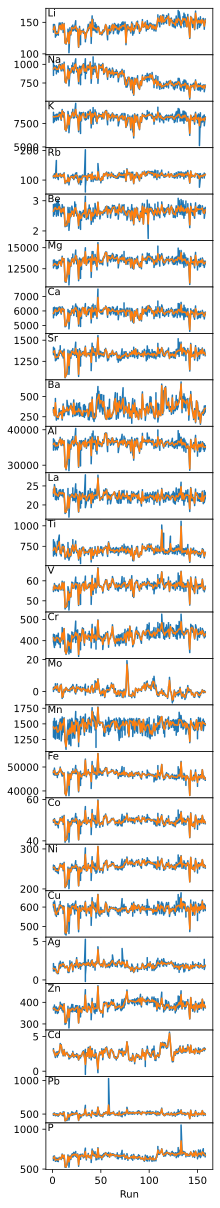

In [27]:
fig_raw = plt.figure(figsize=(3,21))
axes_raw = fig_raw.subplots(nrows=len(elements),
                           sharex=True)

for idx, element in enumerate(elements):
    cur_ax = axes_raw[idx]
    cur_ax.plot(ICP_df["Run"], 
                ICP_df[element],
               label=element)
    # plotting means
    cur_ax.plot(ICP_mean.index,
               ICP_mean[element],
               label=element)
    cur_ax.annotate(element, 
                   xy=(0.01,.99),
                   xycoords="axes fraction",
                   ha="left",
                   va="top")
fig_raw.subplots_adjust(hspace=0)

axes_raw[-1].set_xlabel("Run");

For some elements, the scatter of the data is definitely improved by averaging per run, while for others like Ba not so much.

A good indication for bad run might still be, that it has a low precision. We would like to do a comparison of the standard deviations of each run per element. Again, we will use `.groupby` and then `.agg`. This time with "std".

In [28]:
ICP_std = ICP_df.groupby("Run").agg("std")
ICP_std

Repeat        Li         Na           K         Rb        Be  \
Run                                                                   
1    2.449490  4.026090  59.458209  346.343528   2.940199  0.127272   
2    1.290994  2.429691  24.384602  315.417712   4.373869  0.141274   
3    1.581139  5.015469  14.960002  171.124224   3.541070  0.088769   
4    1.581139  2.888342  46.223828  247.583319  24.466980  0.188494   
5    1.581139  1.486960  21.230641  207.486626   1.317877  0.168285   
..        ...       ...        ...         ...        ...       ...   
154       NaN       NaN        NaN         NaN        NaN       NaN   
155  0.707107  0.035355  29.493424  352.139177   6.703372  0.098995   
156  1.290994  3.270029  15.893379  262.687393   1.994315  0.026300   
157  1.581139  4.295483  41.034417  525.634569   6.379822  0.141421   
158  1.000000  2.874062  13.573741  146.254345   0.937230  0.090738   

             Mg          Ca         Sr         Ba  ...          Mn  \
Run                                                ...               
1    273.607122  206.067950  29.466688  21.009485  ...   93.721091   
2    344.630599  218.116941  36.742346   2.289736  ...  152.220235   
3    140.741607   71.614943  20.278067  41.389672  ...  118.822557   
4    348.530917  204.903148  24.551986  40.373258  ...   72.669113   
5    282.645184  159.772338  18.968395  14.889037  ...   77.632467   
..          ...         ...        ...        ...  ...         ...   
154         NaN         NaN        NaN        NaN  ...         NaN   
155  277.892965  191.625938  18.384776  21.771818  ...   12.020815   
156  203.116346   98.289962  13.022417  27.926483  ...   80.748581   
157  308.930737  176.217763  20.825465  39.101631  ...   26.149570   
158  171.234732   93.468355  10.000000  41.442044  ...   16.502525   

              Fe        Co        Ni         Cu        Ag         Zn  \
Run                                                                    
1     438.288881  0.417217  3.537473   8.126521  0.324629   5.304316   
2    1306.415580  0.733757  3.918600  23.036792  0.268887   9.684559   
3     339.312835  0.723443  3.247176  13.777964  0.183929   9.877258   
4     363.695889  0.538962  2.741801   7.101310  0.111131   8.297251   
5     764.527174  0.607758  3.446556  11.697188  0.071764   8.744780   
..           ...       ...       ...        ...       ...        ...   
154          NaN       NaN       NaN        NaN       NaN        NaN   
155   111.722871  0.098995  0.707107   8.456997  0.219203   1.364716   
156   406.248282  0.705425  3.065349  14.744731  0.027538  11.913441   
157   118.305537  0.179221  0.699371   9.022265  0.539843   8.538653   
158   509.091675  0.422532  3.178412  15.033650  0.046188   4.199171   

           Cd         Pb          P  
Run                                  
1    0.125471  11.391177  16.443492  
2    0.111654   8.688084  13.528784  
3    0.223540   9.250193  12.096936  
4    0.190342   9.089674  12.983322  
5    0.335932  10.003069  14.939912  
..        ...        ...        ...  
154       NaN        NaN        NaN  
155  0.155563   3.973940   1.810193  
156  0.069761  10.267530  36.910937  
157  0.164073   8.817294  14.028139  
158  0.070946  10.837578  22.929364  

[158 rows x 26 columns]

If we count the result columns, we see that instead of 158 we now only have 150 to 151 filled with non-nan values.

In [29]:
ICP_std.count()

Repeat    151
Li        151
Na        151
K         151
Rb        151
Be        151
Mg        151
Ca        151
Sr        151
Ba        151
Al        151
La        151
Ti        151
V         151
Cr        151
Mo        151
Mn        150
Fe        151
Co        151
Ni        151
Cu        151
Ag        151
Zn        151
Cd        151
Pb        151
P         151
dtype: int64

The length of the dataframe is still 158 though:

In [30]:
len(ICP_std)

158

Hence, a few of our groups must unexpectedly have resulted in `nan`s, when we tried to calculate the standard deviation. Which ones?  To figure that out, we can use boolean indexing. 



So, step one: create boolean array called `isnan` that is true wherever there are `nan`s in a column.

And then, step two, use it to select elements from the index of `ICP_std`:

In [31]:
isnan = np.isnan(ICP_std["Repeat"])

ICP_std.index[isnan]

Int64Index([36, 86, 94, 112, 139, 149, 154], dtype='int64', name='Run')

What do these runs have in common? We can again use logical indexing to check out all rows of those run from the raw data frame.

In [32]:
ICP_df[ICP_df["Run"] == 36]

Run  Repeat      Li      Na     K      Rb    Be     Mg    Ca    Sr  ...  \
132   36       1  136.14  978.48  8536  100.02  2.49  13455  5931  1337  ...   

         Mn     Fe     Co      Ni      Cu    Ag      Zn    Cd     Pb       P  
132  1423.0  47359  48.42  246.05  585.77  1.92  355.67  2.16  477.7  666.96  

[1 rows x 27 columns]

In [33]:
ICP_df[ICP_df["Run"] == 86]

Run  Repeat      Li      Na     K      Rb    Be     Mg    Ca    Sr  ...  \
291   86       1  140.58  733.45  7663  108.12  2.46  13127  5629  1396  ...   

         Mn     Fe     Co      Ni      Cu    Ag      Zn    Cd      Pb      P  
291  1535.0  47610  50.79  266.18  605.41  1.43  401.72  1.91  521.02  654.1  

[1 rows x 27 columns]

After checking the first two runs, there is good reason to suspect that the `nan`s were caused by runs that only had a single repeat (and thus no standard deviation). To be sure, we use `groupby` and `agg` a dataframe of counts of repeats and then select the problematic runs. And...

In [34]:
 ICP_df.groupby("Run").agg("count")[isnan]

Repeat  Li  Na  K  Rb  Be  Mg  Ca  Sr  Ba  ...  Mn  Fe  Co  Ni  Cu  Ag  \
Run                                             ...                           
36        1   1   1  1   1   1   1   1   1   1  ...   1   1   1   1   1   1   
86        1   1   1  1   1   1   1   1   1   1  ...   1   1   1   1   1   1   
94        1   1   1  1   1   1   1   1   1   1  ...   1   1   1   1   1   1   
112       1   1   1  1   1   1   1   1   1   1  ...   1   1   1   1   1   1   
139       1   1   1  1   1   1   1   1   1   1  ...   1   1   1   1   1   1   
149       1   1   1  1   1   1   1   1   1   1  ...   1   1   1   1   1   1   
154       1   1   1  1   1   1   1   1   1   1  ...   1   1   1   1   1   1   

     Zn  Cd  Pb  P  
Run                 
36    1   1   1  1  
86    1   1   1  1  
94    1   1   1  1  
112   1   1   1  1  
139   1   1   1  1  
149   1   1   1  1  
154   1   1   1  1  

[7 rows x 26 columns]

... our suspicion is confirmed. In order to proceed, we will remove all `nan`s. This removes all rows where there is at least one `nan`:

In [35]:
ICP_std = ICP_std.dropna()
ICP_std.count()

Repeat    150
Li        150
Na        150
K         150
Rb        150
Be        150
Mg        150
Ca        150
Sr        150
Ba        150
Al        150
La        150
Ti        150
V         150
Cr        150
Mo        150
Mn        150
Fe        150
Co        150
Ni        150
Cu        150
Ag        150
Zn        150
Cd        150
Pb        150
P         150
dtype: int64

ICP_std still contains a column for "Repeat" (which makes little sense). We only want to look at element columns. To select specific columns, we can use a list to index:

In [36]:
ICP_std = ICP_std[elements]

### Correlations

Let's see if the standard deviation of a run is  correlated to its error (hinting at less talented experimenters getting worse results overall). 

To calculate the deviation from the mean, we subtract the column means from the columns and then calculate the absolute value. We calculate the column by column correlation using the `.corrwith` method:

In [37]:
ICP_std.corrwith( (ICP_mean-ICP_df.mean()).abs()).dropna()

Li    0.123473
Na   -0.042372
K     0.060725
Rb    0.018555
Be    0.162011
Mg    0.045953
Ca    0.001102
Sr    0.067393
Ba   -0.036266
Al    0.056276
La   -0.036720
Ti    0.220695
V     0.085825
Cr    0.208214
Mo    0.396611
Mn   -0.125482
Fe    0.023930
Co    0.094088
Ni    0.070000
Cu    0.222453
Ag    0.056906
Zn    0.095673
Cd    0.300720
Pb    0.444630
P     0.406824
dtype: float64

Overall, there are some slightly positive correlations - we could determine the significance of those correlations to see if we are just deluding ourselves. All in all this is a mixed bag, though. If we go back to our intial plots, it seems like some element concentrations are always moving in the same direction, while others appear uncorrelated. Maybe, we will better understand what it happening by looking at correlated elements. We will use mean values again to plot the intercolumn correlation coefficient. First, let's remove everything but the elements here, too.

In [38]:
ICP_mean = ICP_mean[elements]

In [39]:
corr = ICP_mean.corr()

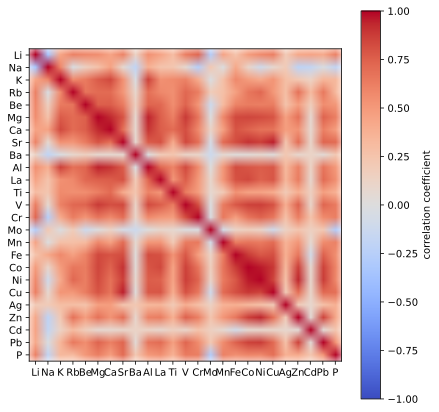

In [40]:
fig_corr = plt.figure(figsize=(7,7))
ax = fig_corr.add_subplot()
mappable = ax.imshow(corr, vmin=-1, vmax=1, 
          cmap=plt.cm.coolwarm, interpolation="none")
ax.set_xticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns)
ax.set_yticks(range(len(corr.index)))
ax.set_yticklabels(corr.index)
fig_corr.colorbar(mappable, label="correlation coefficient")

Overall, it seems like most elements are correlated positively, except for Na, Mo, Cd and Ba.  Some of the elements in that group are also somewhat correlated positively with each other. Still, unfortunately, even this very condensed representation seems a bit too rich in information for me. 

### Principal component analysis finds correlations

A [principal component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) could help. Luckily, PCA is provided by `scikit-learn`. 

(This will give as a chance to dive in to the idiosyncrasies of that library as well).

First, we need to import PCA from `sklearn.decomposition`
 

In [41]:
from sklearn.decomposition import PCA

In `sklearn` functions that do something to your data, be it fitting it or normalizing it, are actually implemented as classed. Using such class is a two (three) step process.

First we create an instance of the class:

In [42]:
pca = PCA()

In this step you usually set the hyperparameters/settings for the object as well. (In the line of code `pca` is called an object or an instance of `PCA` while `PCA` the class).


Then we fit the object to the dataset. 

It is usually a good idea to normalize data of different scales before we apply the PCA. We do that be subtracting the mean and dividing by the standard deviation

In [43]:
ICP_normalized = (ICP_mean - ICP_mean.mean())/ICP_mean.std()
ICP_normalized

Li        Na         K        Rb        Be        Mg        Ca  \
Run                                                                         
1   -0.459028  1.118622  0.216925 -0.219111  0.183876 -0.824879 -0.314559   
2    0.085735  1.311168  0.143487  0.132906  0.765708 -0.493278  0.150031   
3   -1.058376  1.254150  0.290944 -0.471028  0.978203 -0.566036  0.687919   
4   -1.182708  1.044334  0.253789  1.004514  0.573451 -0.812344  0.186680   
5   -1.116426  1.092698  0.346211 -0.238385  0.627418 -0.824202  0.241468   
..        ...       ...       ...       ...       ...       ...       ...   
154  0.589343 -1.130072 -0.672749 -0.034854  0.681385 -0.279410 -0.270136   
155  1.221290 -1.305242 -0.521810 -0.300061  0.883761  0.299092 -0.038767   
156  0.905317 -1.067488 -0.208319  0.333662 -0.111256 -0.413660 -0.604234   
157  0.101114 -1.418746 -0.780033  0.123531 -0.330496 -0.585686 -1.059385   
158  1.107753 -1.051918 -0.034932  0.588076  0.456522 -0.232543 -0.175121   

           Sr        Ba        Al  ...        Mn        Fe        Co  \
Run                                ...                                 
1    0.445809 -0.183304  0.007849  ... -0.314397  0.503870  0.132200   
2    0.730821 -0.963738  0.216434  ... -0.695255  0.866418  0.354379   
3   -0.769054  0.838914 -0.350303  ... -0.490131  0.079830 -0.508428   
4   -0.630110 -1.004628 -0.230779  ... -0.262216  0.159425 -0.438421   
5   -0.580233 -1.227988 -0.306322  ... -1.281836  0.055854 -0.560251   
..        ...       ...       ...  ...       ...       ...       ...   
154  0.125171 -0.754761 -0.510703  ... -0.881185 -0.662641 -0.313864   
155  1.069272 -0.558767  0.193958  ...  0.732213  0.989937  1.277192   
156  0.120717 -0.597662 -0.362107  ...  0.396338 -0.665311 -0.239994   
157  0.395932 -0.082639 -0.593491  ...  0.455116 -0.388328  0.209821   
158 -0.142028  0.065939 -0.486126  ...  0.190415 -0.893339 -0.306288   

           Ni        Cu        Ag        Zn        Cd        Pb         P  
Run                                                                        
1   -0.286637  0.870121 -1.037185 -0.543948  0.571157 -0.201088 -0.739377  
2   -0.247969  0.929320 -1.297455 -0.464432 -0.025681  0.033078 -0.300197  
3   -0.749737 -0.741595 -1.266917 -0.833065 -0.632834 -0.580216 -1.419968  
4   -0.851342 -1.066741 -2.116437 -0.814878 -0.078733 -0.457543 -1.189329  
5   -0.915310 -0.416527 -2.727203 -0.976514 -0.335152 -0.663516 -1.187805  
..        ...       ...       ...       ...       ...       ...       ...  
154  0.117705 -0.015141  0.160055 -0.516624  0.386948 -0.435797  0.224244  
155  1.264603  1.600885 -0.547879  1.259620  0.534315  1.645243  1.301239  
156 -0.106424  0.066282 -0.443771 -0.193865  0.829050 -0.404189  1.004927  
157  0.218018  0.671486 -0.356320  0.227943  0.737682  0.120279  0.528556  
158 -0.194057  0.146216 -0.025026 -0.308567  0.819226 -0.263129  0.173709  

[158 rows x 25 columns]

In [44]:
pca.fit(ICP_normalized)

PCA()

Once an object has been fit to a dataset, it can be used to transform datasets, either the original one or a new one of the same shape. In this case we are not interested in using `pca` to transform data but want to use the loadings of the PCA to see trends in the dataset. After calling `.fit` these are stored in the `components_` attribute of `pca`, row wise. Typically, only the first few components are useful (the rest just describes noise in the dataset). Let's plot a few loadings vectors. 

We select the first 5 components/loadings vectors and use `enumerate` to  get an index (for the plot legend). The x-axis in this plot contains element names, the y axis shows how much and in which direction the principal component correlates with the concentration of an element. 

We will scale each y axis symmetrically and draw a gray zero line to make the figure easier to read. We will also add the `pca.explained_variance_ratio_` attribute that shows us which fraction of the overall variance in a dataset a component describes so we don't accidentally start interpreting negligible changes.

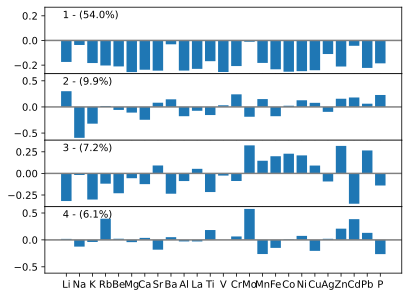

In [45]:
N_components = 4


fig_components = plt.figure()
axes = fig_components.subplots(nrows=N_components, sharex=True)
for idx, comp in enumerate(pca.components_[:N_components]):
    axes[idx].bar(range(len(elements)), comp)
    ylim = axes[idx].get_ylim()
    axes[idx].set_ylim(-max(abs(np.array(ylim))), max(abs(np.array(ylim))))
    axes[idx].axhline(0, color="gray")
    axes[idx].annotate("{} - ({:.1f}%)".format(idx+1, pca.explained_variance_ratio_[idx]*100), 
                   xy=(0.05,.95),
                   xycoords="axes fraction",
                   ha="left",
                   va="top")
fig_components.subplots_adjust(hspace=0)

axes[idx].set_xticks(range(len(elements)))
axes[idx].set_xticklabels(elements);

The correlations we saw before regarding Na, Mo, Cd and Ba show up again in this plot as well (component 1). However, now it seems like they are just not moving the same direction as the other elements as much and Ag also seems to belong to this group.

We now also see, that Na and Li seem to be quite strongly anti-correlated (component 2), more strongly  so than the other elements with weak/strong correlation with the first component.



The interpretation of the factors of influence according to the [source](https://dx.doi.org/10.1039/b004577m) of this dataset is as follows:

**1st component**: Na, Mo, Cd and Ba already close to the limit of detection, hence when the sample amount (inaccurate weigh-in or dilution) is off, they are less affected, because they area already at the lower limit

**2nd component**: Na, K, Be, Mg, Ca, Al, Ti are strongly affected by digestion/decomposition.



And that brings us already to the end of this section. We have one final section ahead, where we will look a bit more at `scikit-learn`. 

The important take away message in this section was, how the tools in `pandas`, `scipy`/`numpy`, `matplotlib` and `sklearn` fit together to work with larger dataset. We have just scratched the surface here. There is no yellow brick road to understanding and using all these tools perfectly (although there is a python library called `yellowbrick`), they are just too complex for that. There will be a few things that you know how to do without looking up any documentation, for the rest there is documentation, `?` and `help()`.

## Summary

**1. `pandas`**

**column wise calculations:**
1. built-in `.mean()`, `.std()`,...
2. `.apply()` to use custom function

**statistical testing**

1. check function in `scikit.stats`
2. apply using `DataFrame.apply()`
3. logical indexing after comparison with $\alpha$ to keep only some columns

**GroupBy and Aggregate**

1. GroupBy one/multiple columns
2. Aggregate using multiple functions
3. `.rename` to make it look nicer

**2. `matplotlib`**

1. `figure.subplots` to create multiple axes
2.  `.axhline`, `.axvline` to create vertical and horizontal lines
3. `figure.subplots_adjust(hspace=0)` to remove space between axes in figure 

**3. `scikit-learn`**

typical procedure:

1. create instance 
2. `.fit` to data
3. read value or use to `.transform`

